### Generate samples

In [1]:
from APES import *
from time import time
from matplotlib import font_manager
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
ticks_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=15, weight='normal', stretch='normal')
legend_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=12, weight='normal', stretch='normal')
hfont =  {'fontname':'helvetica-light-587ebe5a59211'}
csfont = {'fontname':'helvetica-light-587ebe5a59211'}
def calculate(val,index):
    mean = np.mean(val[:,index,:],axis=0)
    std = np.std(val[:,index,:],axis=0)
    return mean,std/np.sqrt(20)

In [21]:
Ego = True
if Ego:
    unique_count=26400
else:
    unique_count=31200
all_simu = np.load('in_out_{}_seq_EGO_{}.npz'.format(unique_count,Ego))

data = all_simu['input_target']
action_sequence = all_simu['action_sequence']

if Ego:
    cnn_input = data[:,:693]
    rest_input = data[:,693:697]
    y = data[:,697]
    cnn_input = cnn_input.reshape((data.shape[0],11,21,3))
    rest_input = rest_input.reshape((data.shape[0],4))
else:
    cnn_input = data[:,:676]
    rest_input = data[:,676:684]
    y = data[:,684]
    cnn_input = cnn_input.reshape((data.shape[0],13,13,4))
    rest_input = rest_input.reshape((data.shape[0],8))
    
y = y.reshape((data.shape[0],1))

print(cnn_input.shape,rest_input.shape,y.shape)

(26400, 11, 21, 3) (26400, 4) (26400, 1)


0: Forward, 1:Backword,2:Right,3:left,4:nothing



In [22]:
Settings.PossibleActions

array([list([['L', 'N'], ['M', 'N']]), list([['L', 'S'], ['M', 'S']]),
       list([['L', 'W'], ['M', 'W']]), list([['L', 'E'], ['M', 'E']]),
       list([])], dtype=object)

In [23]:
locations = np.where(y==0)[0]

In [30]:
print(cnn_input[locations][1][:,:,1])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [25]:
action_sequence[locations][1]

array([ 0,  3,  4,  4,  0,  2,  0,  3,  2,  3,  2,  3,  0,  0,  4,  2, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      dtype=int8)

In [19]:
action_sequence[action_sequence==-1]=7

In [20]:
np.bincount(action_sequence[locations].flatten())

array([ 66557,   5241,  17708,  18054,  70490,      0,      0, 921950])

In [14]:
action_sequence[locations].bincount()

AttributeError: 'numpy.ndarray' object has no attribute 'bincount'

## Allocentric decision test

# Classifires

In [1]:
from keras.layers import Input,convolutional,Flatten,merge,Dense
from keras.models import load_model,Model
from APES import *
from time import time

def createLayers(insize,in_conv,naction):
    c = Input(shape=in_conv)
    con_process = c
    con_process = convolutional.Conv2D(filters=6,kernel_size=(3,3),activation="relu",padding="same",strides=1)(con_process)
    con_process = Flatten()(con_process)
    x = Input(shape=insize)#env.observation_space.shape)
    h = merge([con_process,x],mode="concat")
    h = Dense(32, activation='tanh')(h)
    h = Dense(32, activation='tanh')(h)
    z = Dense(1, activation='sigmoid')(h)
    return c,x, z

Using TensorFlow backend.
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

### Classify Allocentric

In [4]:
Ego = False
if Ego:
    conv_size=(11,21,3,)
    rest_size=(4,)
else:
    conv_size=(13,13,4,)
    rest_size=(8,)
naction =  Settings.PossibleActions.shape[0]

print(conv_size,naction,rest_size)
all_simu = np.load('ego:{}_simulation_31200_unique_E.npz'.format(Ego))
cnn_input= all_simu['cnn_input']
rest_input = all_simu['rest_input']
y = all_simu['y']

(13, 13, 4) 5 (8,)


In [5]:
num_exper= 20
epochs=20
info = np.zeros((num_exper,4,epochs))
for i in range(num_exper):
    c,x,z = createLayers(rest_size,conv_size,naction)

    allo_classifier = Model(inputs=[c,x],outputs=z)

    allo_classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    allo_classifier.summary()

    allo_history = allo_classifier.fit([all_simu['cnn_input'],all_simu['rest_input']],
                                       all_simu['y'],epochs=epochs,batch_size=64,validation_split=0.2)
    
    info[i,0,:] = allo_history.history['val_loss']
    info[i,1,:] = allo_history.history['val_acc']
    info[i,2,:] = allo_history.history['loss']
    info[i,3,:] = allo_history.history['acc']

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 13, 13, 4)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 13, 13, 6)     222         input_1[0][0]                    
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1014)          0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 8)    

/gpfs/hpc/home/labash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 3s - loss: 0.6818 - acc: 0.5813 - val_loss: 0.6806 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.6787 - acc: 0.5837 - val_loss: 0.6722 - val_acc: 0.6151
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.5128 - acc: 0.7548 - val_loss: 0.3222 - val_acc: 0.9048
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.1700 - acc: 0.9686 - val_loss: 0.0861 - val_acc: 0.9966
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.0580 - acc: 0.9983 - val_loss: 0.0370 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0265 - acc: 0.9999 - val_loss: 0.0182 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.0136 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 3s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 4s - loss: 0.6816 - acc: 0.5809 - val_loss: 0.6806 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.5501 - acc: 0.7281 - val_loss: 0.3570 - val_acc: 0.8896
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.2022 - acc: 0.9674 - val_loss: 0.1139 - val_acc: 0.9950
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.0762 - acc: 0.9986 - val_loss: 0.0494 - val_acc: 0.9994
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.0318 - acc: 1.0000 - val_loss: 0.0213 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0153 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 3s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 4s - loss: 0.6811 - acc: 0.5792 - val_loss: 0.6751 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.5092 - acc: 0.7568 - val_loss: 0.2903 - val_acc: 0.9393
Epoch 3/20
24960/24960 [==============================] - 3s - loss: 0.1465 - acc: 0.9831 - val_loss: 0.0772 - val_acc: 0.9976
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.0462 - acc: 0.9993 - val_loss: 0.0285 - val_acc: 1.0000
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.0196 - acc: 0.9999 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0097 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 2s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 2s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 3s - loss: 0.6820 - acc: 0.5819 - val_loss: 0.6842 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 2s - loss: 0.6278 - acc: 0.6379 - val_loss: 0.4569 - val_acc: 0.8226
Epoch 3/20
24960/24960 [==============================] - 2s - loss: 0.2373 - acc: 0.9509 - val_loss: 0.1066 - val_acc: 0.9947
Epoch 4/20
24960/24960 [==============================] - 2s - loss: 0.0615 - acc: 0.9995 - val_loss: 0.0348 - val_acc: 1.0000
Epoch 5/20
24960/24960 [==============================] - 2s - loss: 0.0224 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 2s - loss: 0.0109 - acc: 1.0000 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 2s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 2s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 4s - loss: 0.6820 - acc: 0.5819 - val_loss: 0.6796 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.6803 - acc: 0.5837 - val_loss: 0.6801 - val_acc: 0.5821
Epoch 3/20
24960/24960 [==============================] - 2s - loss: 0.6799 - acc: 0.5837 - val_loss: 0.6794 - val_acc: 0.5821
Epoch 4/20
24960/24960 [==============================] - 2s - loss: 0.6784 - acc: 0.5838 - val_loss: 0.6590 - val_acc: 0.6112
Epoch 5/20
24960/24960 [==============================] - 3s - loss: 0.3222 - acc: 0.9029 - val_loss: 0.1062 - val_acc: 0.9979
Epoch 6/20
24960/24960 [==============================] - 3s - loss: 0.0549 - acc: 0.9989 - val_loss: 0.0270 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 2s - loss: 0.0169 - acc: 1.0000 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 2s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 3s - loss: 0.6814 - acc: 0.5823 - val_loss: 0.6814 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 2s - loss: 0.6804 - acc: 0.5837 - val_loss: 0.6813 - val_acc: 0.5821
Epoch 3/20
24960/24960 [==============================] - 2s - loss: 0.6798 - acc: 0.5837 - val_loss: 0.6825 - val_acc: 0.5821
Epoch 4/20
24960/24960 [==============================] - 2s - loss: 0.6796 - acc: 0.5837 - val_loss: 0.6798 - val_acc: 0.5821
Epoch 5/20
24960/24960 [==============================] - 2s - loss: 0.6800 - acc: 0.5837 - val_loss: 0.6796 - val_acc: 0.5821
Epoch 6/20
24960/24960 [==============================] - 2s - loss: 0.6800 - acc: 0.5837 - val_loss: 0.6797 - val_acc: 0.5821
Epoch 7/20
24960/24960 [==============================] - 2s - loss: 0.6795 - acc: 0.5837 - val_loss: 0.6796 - val_acc: 0.5821
Epoch 8/20
24960/24960 [==============================] - 2s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 3s - loss: 0.6703 - acc: 0.6002 - val_loss: 0.5988 - val_acc: 0.7122
Epoch 2/20
24960/24960 [==============================] - 2s - loss: 0.4891 - acc: 0.7595 - val_loss: 0.3806 - val_acc: 0.8574
Epoch 3/20
24960/24960 [==============================] - 2s - loss: 0.2145 - acc: 0.9532 - val_loss: 0.1084 - val_acc: 0.9954
Epoch 4/20
24960/24960 [==============================] - 2s - loss: 0.0643 - acc: 0.9979 - val_loss: 0.0377 - val_acc: 0.9998
Epoch 5/20
24960/24960 [==============================] - 2s - loss: 0.0258 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 2s - loss: 0.0124 - acc: 1.0000 - val_loss: 0.0092 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 3s - loss: 0.0071 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 2s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 3s - loss: 0.6809 - acc: 0.5806 - val_loss: 0.6665 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 2s - loss: 0.4380 - acc: 0.8284 - val_loss: 0.2334 - val_acc: 0.9587
Epoch 3/20
24960/24960 [==============================] - 2s - loss: 0.1420 - acc: 0.9861 - val_loss: 0.0831 - val_acc: 0.9976
Epoch 4/20
24960/24960 [==============================] - 2s - loss: 0.0557 - acc: 0.9988 - val_loss: 0.0358 - val_acc: 1.0000
Epoch 5/20
24960/24960 [==============================] - 2s - loss: 0.0246 - acc: 1.0000 - val_loss: 0.0175 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 2s - loss: 0.0126 - acc: 1.0000 - val_loss: 0.0095 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 2s - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 3s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 3s - loss: 0.6807 - acc: 0.5824 - val_loss: 0.6797 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 2s - loss: 0.6076 - acc: 0.6747 - val_loss: 0.4749 - val_acc: 0.7721
Epoch 3/20
24960/24960 [==============================] - 2s - loss: 0.2896 - acc: 0.9213 - val_loss: 0.1654 - val_acc: 0.9604
Epoch 4/20
24960/24960 [==============================] - 2s - loss: 0.0885 - acc: 0.9940 - val_loss: 0.0497 - val_acc: 1.0000
Epoch 5/20
24960/24960 [==============================] - 2s - loss: 0.0312 - acc: 0.9997 - val_loss: 0.0203 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 2s - loss: 0.0127 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 2s - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 2s -

Train on 24960 samples, validate on 6240 samples
Epoch 1/20
24960/24960 [==============================] - 4s - loss: 0.6825 - acc: 0.5802 - val_loss: 0.6801 - val_acc: 0.5821
Epoch 2/20
24960/24960 [==============================] - 3s - loss: 0.6802 - acc: 0.5837 - val_loss: 0.6805 - val_acc: 0.5821
Epoch 3/20
24960/24960 [==============================] - 2s - loss: 0.5760 - acc: 0.6901 - val_loss: 0.3763 - val_acc: 0.8647
Epoch 4/20
24960/24960 [==============================] - 3s - loss: 0.1930 - acc: 0.9655 - val_loss: 0.0935 - val_acc: 0.9957
Epoch 5/20
24960/24960 [==============================] - 2s - loss: 0.0523 - acc: 0.9998 - val_loss: 0.0299 - val_acc: 1.0000
Epoch 6/20
24960/24960 [==============================] - 2s - loss: 0.0204 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 1.0000
Epoch 7/20
24960/24960 [==============================] - 2s - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0088 - val_acc: 1.0000
Epoch 8/20
24960/24960 [==============================] - 2s -

### Ego centric decision

In [8]:
Ego = True
if Ego:
    conv_size=(11,21,3,)
    rest_size=(4,)
else:
    conv_size=(13,13,4,)
    rest_size=(8,)
naction =  Settings.PossibleActions.shape[0]

print(conv_size,naction,rest_size)
all_simu = np.load('ego:{}_simulation_26400_unique_E.npz'.format(Ego))
#all_simu = np.load('ego:{}_simulation_200000.npz'.format(Ego))

(11, 21, 3) 5 (4,)


In [9]:
ego_info = np.zeros((num_exper,4,epochs))
for i in range(num_exper):
    c,x,z = createLayers(rest_size,conv_size,naction)

    ego_classifier = Model(inputs=[c,x],outputs=z)

    ego_classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    ego_classifier.summary()

    ego_history = ego_classifier.fit([all_simu['cnn_input'],all_simu['rest_input']],
                                       all_simu['y'],epochs=epochs,batch_size=64,validation_split=0.2)
    
    ego_info[i,0,:] = ego_history.history['val_loss']
    ego_info[i,1,:] = ego_history.history['val_acc']
    ego_info[i,2,:] = ego_history.history['loss']
    ego_info[i,3,:] = ego_history.history['acc']

/gpfs/hpc/home/labash/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if sys.path[0] == '':
/gpfs/hpc/home/labash/miniconda3/envs/PT_old/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_41 (InputLayer)            (None, 11, 21, 3)     0                                            
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 11, 21, 6)     168         input_41[0][0]                   
____________________________________________________________________________________________________
flatten_21 (Flatten)             (None, 1386)          0           conv2d_21[0][0]                  
____________________________________________________________________________________________________
input_42 (InputLayer)            (None, 4)             0                                            
___________________________________________________________________________________________

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6802 - acc: 0.5855 - val_loss: 0.6843 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6785 - acc: 0.5863 - val_loss: 0.6830 - val_acc: 0.5716
Epoch 3/20
21120/21120 [==============================] - 3s - loss: 0.6769 - acc: 0.5863 - val_loss: 0.6799 - val_acc: 0.5716
Epoch 4/20
21120/21120 [==============================] - 3s - loss: 0.6730 - acc: 0.5863 - val_loss: 0.6793 - val_acc: 0.5716
Epoch 5/20
21120/21120 [==============================] - 3s - loss: 0.6696 - acc: 0.5862 - val_loss: 0.6767 - val_acc: 0.5716
Epoch 6/20
21120/21120 [==============================] - 2s - loss: 0.6673 - acc: 0.5860 - val_loss: 0.6759 - val_acc: 0.5716
Epoch 7/20
21120/21120 [==============================] - 2s - loss: 0.6658 - acc: 0.5868 - val_loss: 0.6790 - val_acc: 0.5716
Epoch 8/20
21120/21120 [==============================] - 2s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6807 - acc: 0.5843 - val_loss: 0.6850 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6795 - acc: 0.5863 - val_loss: 0.6837 - val_acc: 0.5716
Epoch 3/20
21120/21120 [==============================] - 2s - loss: 0.6791 - acc: 0.5863 - val_loss: 0.6858 - val_acc: 0.5716
Epoch 4/20
21120/21120 [==============================] - 2s - loss: 0.6464 - acc: 0.6223 - val_loss: 0.5396 - val_acc: 0.7229
Epoch 5/20
21120/21120 [==============================] - 2s - loss: 0.4391 - acc: 0.7644 - val_loss: 0.3937 - val_acc: 0.7693
Epoch 6/20
21120/21120 [==============================] - 2s - loss: 0.3808 - acc: 0.7795 - val_loss: 0.3698 - val_acc: 0.7775
Epoch 7/20
21120/21120 [==============================] - 2s - loss: 0.3624 - acc: 0.7818 - val_loss: 0.3688 - val_acc: 0.7623
Epoch 8/20
21120/21120 [==============================] - 2s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6811 - acc: 0.5842 - val_loss: 0.6837 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6784 - acc: 0.5863 - val_loss: 0.6832 - val_acc: 0.5716
Epoch 3/20
21120/21120 [==============================] - 2s - loss: 0.6752 - acc: 0.5864 - val_loss: 0.6771 - val_acc: 0.5716
Epoch 4/20
21120/21120 [==============================] - 2s - loss: 0.6262 - acc: 0.6505 - val_loss: 0.5450 - val_acc: 0.7212
Epoch 5/20
21120/21120 [==============================] - 2s - loss: 0.4565 - acc: 0.7623 - val_loss: 0.4070 - val_acc: 0.7720
Epoch 6/20
21120/21120 [==============================] - 2s - loss: 0.3831 - acc: 0.7802 - val_loss: 0.3798 - val_acc: 0.7695
Epoch 7/20
21120/21120 [==============================] - 2s - loss: 0.3529 - acc: 0.7944 - val_loss: 0.3550 - val_acc: 0.7856
Epoch 8/20
21120/21120 [==============================] - 2s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6836 - acc: 0.5821 - val_loss: 0.6868 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6797 - acc: 0.5861 - val_loss: 0.6847 - val_acc: 0.5716
Epoch 3/20
21120/21120 [==============================] - 2s - loss: 0.6792 - acc: 0.5863 - val_loss: 0.6830 - val_acc: 0.5716
Epoch 4/20
21120/21120 [==============================] - 2s - loss: 0.6793 - acc: 0.5863 - val_loss: 0.6847 - val_acc: 0.5716
Epoch 5/20
21120/21120 [==============================] - 2s - loss: 0.6792 - acc: 0.5863 - val_loss: 0.6836 - val_acc: 0.5716
Epoch 6/20
21120/21120 [==============================] - 2s - loss: 0.6790 - acc: 0.5863 - val_loss: 0.6830 - val_acc: 0.5716
Epoch 7/20
21120/21120 [==============================] - 2s - loss: 0.6798 - acc: 0.5863 - val_loss: 0.6831 - val_acc: 0.5716
Epoch 8/20
21120/21120 [==============================] - 2s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6811 - acc: 0.5855 - val_loss: 0.6845 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6786 - acc: 0.5863 - val_loss: 0.6833 - val_acc: 0.5716
Epoch 3/20
21120/21120 [==============================] - 2s - loss: 0.6776 - acc: 0.5863 - val_loss: 0.6819 - val_acc: 0.5716
Epoch 4/20
21120/21120 [==============================] - 2s - loss: 0.6738 - acc: 0.5863 - val_loss: 0.6776 - val_acc: 0.5716
Epoch 5/20
21120/21120 [==============================] - 2s - loss: 0.6697 - acc: 0.5859 - val_loss: 0.6749 - val_acc: 0.5716
Epoch 6/20
21120/21120 [==============================] - 2s - loss: 0.6676 - acc: 0.5845 - val_loss: 0.6748 - val_acc: 0.5712
Epoch 7/20
21120/21120 [==============================] - 2s - loss: 0.6661 - acc: 0.5860 - val_loss: 0.6744 - val_acc: 0.5716
Epoch 8/20
21120/21120 [==============================] - 2s -

dense_100 (Dense)                (None, 32)            44512       merge_34[0][0]                   
____________________________________________________________________________________________________
dense_101 (Dense)                (None, 32)            1056        dense_100[0][0]                  
____________________________________________________________________________________________________
dense_102 (Dense)                (None, 1)             33          dense_101[0][0]                  
Total params: 45,769
Trainable params: 45,769
Non-trainable params: 0
____________________________________________________________________________________________________
Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6797 - acc: 0.5851 - val_loss: 0.6836 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6787 - acc: 0.5863 - val_loss: 0.6833 - val_acc: 0.5716
Epoch 3/20
21120/2112

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6808 - acc: 0.5848 - val_loss: 0.6841 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6789 - acc: 0.5863 - val_loss: 0.6837 - val_acc: 0.5716
Epoch 3/20
21120/21120 [==============================] - 2s - loss: 0.6648 - acc: 0.6091 - val_loss: 0.6009 - val_acc: 0.7068
Epoch 4/20
21120/21120 [==============================] - 2s - loss: 0.5243 - acc: 0.7342 - val_loss: 0.4991 - val_acc: 0.7265
Epoch 5/20
21120/21120 [==============================] - 2s - loss: 0.4109 - acc: 0.7695 - val_loss: 0.3878 - val_acc: 0.7739
Epoch 6/20
21120/21120 [==============================] - 2s - loss: 0.3777 - acc: 0.7776 - val_loss: 0.3837 - val_acc: 0.7589
Epoch 7/20
21120/21120 [==============================] - 2s - loss: 0.3631 - acc: 0.7805 - val_loss: 0.3705 - val_acc: 0.7731
Epoch 8/20
21120/21120 [==============================] - 2s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6815 - acc: 0.5841 - val_loss: 0.6840 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6795 - acc: 0.5863 - val_loss: 0.6874 - val_acc: 0.5716
Epoch 3/20
21120/21120 [==============================] - 2s - loss: 0.6740 - acc: 0.5938 - val_loss: 0.6455 - val_acc: 0.7123
Epoch 4/20
21120/21120 [==============================] - 2s - loss: 0.5102 - acc: 0.7454 - val_loss: 0.4173 - val_acc: 0.7625
Epoch 5/20
21120/21120 [==============================] - 2s - loss: 0.3862 - acc: 0.7792 - val_loss: 0.3772 - val_acc: 0.7830
Epoch 6/20
21120/21120 [==============================] - 2s - loss: 0.3600 - acc: 0.7921 - val_loss: 0.3673 - val_acc: 0.7881
Epoch 7/20
21120/21120 [==============================] - 2s - loss: 0.3468 - acc: 0.8068 - val_loss: 0.3544 - val_acc: 0.8140
Epoch 8/20
21120/21120 [==============================] - 2s -

Train on 21120 samples, validate on 5280 samples
Epoch 1/20
21120/21120 [==============================] - 4s - loss: 0.6825 - acc: 0.5839 - val_loss: 0.6871 - val_acc: 0.5716
Epoch 2/20
21120/21120 [==============================] - 2s - loss: 0.6792 - acc: 0.5863 - val_loss: 0.6831 - val_acc: 0.5716
Epoch 3/20
21120/21120 [==============================] - 2s - loss: 0.6316 - acc: 0.6447 - val_loss: 0.5002 - val_acc: 0.7559
Epoch 4/20
21120/21120 [==============================] - 2s - loss: 0.4256 - acc: 0.7737 - val_loss: 0.3878 - val_acc: 0.7782
Epoch 5/20
21120/21120 [==============================] - 2s - loss: 0.3729 - acc: 0.7793 - val_loss: 0.3740 - val_acc: 0.7799
Epoch 6/20
21120/21120 [==============================] - 2s - loss: 0.3581 - acc: 0.7861 - val_loss: 0.3623 - val_acc: 0.7894
Epoch 7/20
21120/21120 [==============================] - 2s - loss: 0.3343 - acc: 0.8136 - val_loss: 0.3213 - val_acc: 0.8288
Epoch 8/20
21120/21120 [==============================] - 2s -

In [10]:
y.shape

(31200, 1)

In [11]:
np.savez('val_train_acc_loss_E.npz',allo=info,ego=ego_info)

### Plot

In [ ]:
from APES import *
from time import time
from matplotlib import font_manager
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
ticks_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=15, weight='normal', stretch='normal')
legend_font = font_manager.FontProperties(family='helvetica-light-587ebe5a59211', style='normal',
    size=12, weight='normal', stretch='normal')
hfont =  {'fontname':'helvetica-light-587ebe5a59211'}
csfont = {'fontname':'helvetica-light-587ebe5a59211'}
def calculate(val,index):
    mean = np.mean(val[:,index,:],axis=0)
    std = np.std(val[:,index,:],axis=0)
    return mean,std/np.sqrt(20)

In [3]:
info = np.load('val_train_acc_loss_E.npz')
ego_info = info['ego']
info = info['allo']

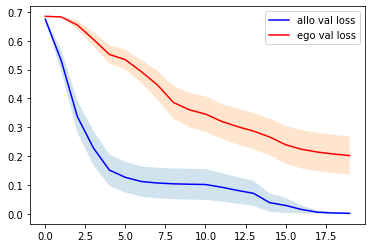

In [4]:
avlm,avls = calculate(info,0)
evlm,evls = calculate(ego_info,0)
plt.plot(avlm,color='b',label='allo val loss')
plt.fill_between(np.arange(20),avlm+avls,avlm-avls,alpha=0.2)

plt.plot(evlm,color='r',label='ego val loss')
plt.fill_between(np.arange(20),evlm+evls,evlm-evls,alpha=0.2)
#plt.ylabel('loss')
#plt.xlabel('Epoch')
plt.legend()

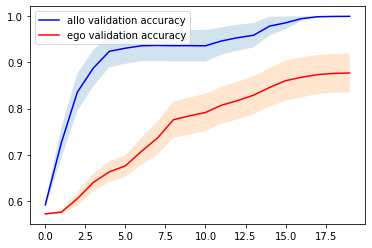

In [6]:
avam,avas = calculate(info,1)
evam,evas = calculate(ego_info,1)
plt.plot(avam,color='b',label='allo validation accuracy')
plt.fill_between(np.arange(20),avam+avas,avam-avas,alpha=0.2)
plt.plot(evam,color='r',label='ego validation accuracy')
plt.fill_between(np.arange(20),evam+evas,evam-evas,alpha=0.2)
atam,avas = calculate(info,3)
etam,evas = calculate(ego_info,3)
#plt.plot(atam,color='black',label='allo training accuracy')

#plt.plot(etam,color='r',label='ego training accuracy')

plt.legend()